In [1]:
import rasterio
from rasterio.plot import show
from os.path import basename, dirname, exists, join, expanduser
from glob import glob
import matplotlib.pyplot as plt
from scipy.signal import correlate2d

In [54]:
work_dir = '/scratch/zacharykeskinen/'
fig_dir = expanduser('~/uavsar/figures/slc_stack')
inc_fp = glob(join(work_dir,'*.tiff'))[0]

isce = {}
isce['coh'] = glob(join(work_dir,'isce','*','*cor*.tif'))
isce['unw'] = glob(join(work_dir,'isce','*','*unw*.tif'))

lidar_sd = glob(join(work_dir,'lidar','banner','snow_depth.tiff'))[0]
lidar_veg = glob(join(work_dir,'lidar','banner','veg_height.tiff'))[0]

jpl = {}
jpl['coh'] = glob(join(work_dir,'jpl','*','tiffs','*HH*cor*.tiff'))
jpl['unw'] = glob(join(work_dir,'jpl','*','tiffs','*HH*unw*.tiff'))

In [134]:
import rasterio
from rasterio.features import shapes
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

def crop(larger_img, smaller_img):
    with rasterio.open(larger_img) as img_to_crop, rasterio.open(smaller_img) as img_ref:
        # get the extents of the larger image as a geometry
        smaller_arr = img_ref.read(1)
        extents, _ = next(shapes(np.zeros_like(smaller_arr), transform=img_ref.profile['transform']))

        # crop the snow_on to the snowoff extents
        cropped_larger, crop_transf = mask(img_to_crop, [extents], crop=True)
        kwargs = img_to_crop.meta.copy()
        kwargs.update({
            'height': cropped_larger.shape[1],
            'width': cropped_larger.shape[2],
            'transform': crop_transf})

        if larger_img.split('.')[-1] == 'tiff':
            larger_clip = larger_img.replace('.tiff','.clip.tiff')
        elif larger_img.split('.')[-1] == 'tif':
            larger_clip = larger_img.replace('.tif','.clip.tiff')
        else:
            raise Exception('Incorrect Extension on File')

        with rasterio.open(larger_clip, 'w', **kwargs) as dst_clip:
            dst_clip.write(cropped_larger)
        return larger_clip

def coarsen(coarser_img, finer_img):
    with rasterio.open(coarser_img) as coarser_src, rasterio.open(finer_img) as finer_src:
    # reproject to match pixels between snow_on and snow_off
        kwargs = finer_src.meta.copy()
        kwargs.update({
            'crs': coarser_src.crs,
            'transform': coarser_src.transform,
            'width': coarser_src.width,
            'height': coarser_src.height
        })
        finer_img_coarsen = finer_img.replace('.tiff','.repro.tiff')
        
        with rasterio.open(finer_img_coarsen, 'w', **kwargs) as dst:
            reproject(
                source=rasterio.band(finer_src, 1),
                #source = finer_src.read(1),
                destination=rasterio.band(dst, 1),
                src_transform=finer_src.transform,
                src_crs=finer_src.crs,
                dst_transform=coarser_src.transform,
                dst_crs=coarser_src.crs,
                resampling=Resampling.nearest)
    
    return finer_img_coarsen

def mask_values(img_to_mask, img_ref):
    with rasterio.open(img_to_mask) as img_to_mask_src, rasterio.open(img_ref) as img_ref_src:
        to_mask = img_to_mask_src.read(1)
        mask = img_ref_src.read(1)
        to_mask[(mask < -99) | (mask > 99) | (mask == 0)] = np.nan
        kwargs = img_to_mask_src.meta.copy()
        masked_img_fp = img_to_mask.replace('.tiff','.ma.tiff')
    with rasterio.open(masked_img_fp, 'w', **kwargs) as src:
        src.write(to_mask, indexes = 1)

    return masked_img_fp

def show_rio(fp, fig = None, ax = None, vmin = None, vmax = None):
    if not ax and not vmin:
        with rasterio.open(fp) as src:
            show(src)
    else:
        with rasterio.open(fp) as src:
            cbar = plt.imshow(src.read(1), vmin = vmin, vmax = vmax)
            show(src, vmin = vmin, vmax = vmax, ax = ax)
            divider = make_axes_locatable(ax)
            cax = divider.append_axes('right', size='5%', pad=0.05)
            fig.colorbar(cbar, cax=cax, orientation='vertical')


def get_rio_array(fp, i = 1):
    with rasterio.open(fp) as src:
        return src.read(i)

# clip interferograms to lidar extent

In [135]:
inc_crop = crop(inc_fp, lidar_sd)

In [59]:
for im_type, im_list in jpl.copy().items():
    if 'clip' not in im_type:
        jpl[f'{im_type}_clip'] = []
        for im in im_list:
            im_clipped = im.replace('.tiff','.clip.tiff')
            if not exists(im_clipped):
                im_clipped = crop(im, lidar_sd)
            jpl[f'{im_type}_clip'].append(im_clipped)
            print(im_clipped)

/scratch/zacharykeskinen/jpl/lowman_23205_21019-018_21021-006_0006d_s01_L090_01_int_grd/tiffs/lowman_23205_21019-018_21021-006_0006d_s01_L090HH_01.cor.grd.clip.tiff
/scratch/zacharykeskinen/jpl/lowman_23205_21017-018_21019-018_0006d_s01_L090_01_int_grd/tiffs/lowman_23205_21017-018_21019-018_0006d_s01_L090HH_01.cor.grd.clip.tiff
/scratch/zacharykeskinen/jpl/lowman_23205_21015-008_21017-018_0007d_s01_L090_01_int_grd/tiffs/lowman_23205_21015-008_21017-018_0007d_s01_L090HH_01.cor.grd.clip.tiff
/scratch/zacharykeskinen/jpl/lowman_23205_21012-000_21015-008_0021d_s01_L090_01_int_grd/tiffs/lowman_23205_21012-000_21015-008_0021d_s01_L090HH_01.cor.grd.clip.tiff
/scratch/zacharykeskinen/jpl/lowman_23205_21009-004_21012-000_0007d_s01_L090_01_int_grd/tiffs/lowman_23205_21009-004_21012-000_0007d_s01_L090HH_01.cor.grd.clip.tiff
/scratch/zacharykeskinen/jpl/lowman_23205_21004-003_21008-000_0007d_s01_L090_01_int_grd/tiffs/lowman_23205_21004-003_21008-000_0007d_s01_L090HH_01.cor.grd.clip.tiff
/scratch/z

In [ ]:
for im_type, im_list in isce.copy().items():
    if 'clip' not in im_type:
        isce[f'{im_type}_clip'] = []
        for im in im_list:
            im_clipped = im.replace('.tif','.clip.tif')
            if not exists(im_clipped):
                im_clipped = crop(im, lidar_sd)
            isce[f'{im_type}_clip'].append(im_clipped)
            print(im_clipped)

/scratch/zacharykeskinen/isce/20200221_20200311/merged_20200221_20200311.cor.clip.tiff
/scratch/zacharykeskinen/isce/20200131_20200311/merged_20200131_20200311.cor.clip.tiff
/scratch/zacharykeskinen/isce/20200213_20200311/merged_20200213_20200311.cor.clip.tiff
/scratch/zacharykeskinen/isce/20200131_20200213/merged_20200131_20200213.cor.clip.tiff
/scratch/zacharykeskinen/isce/20200213_20200221/merged_20200213_20200221.cor.clip.tiff


KeyboardInterrupt: 

warp lidar to match interferogram pixels

In [137]:
inc_crop_reproj = coarsen(jpl['coh_clip'][0], inc_crop)

In [60]:
lidar_sd_reproj = coarsen(jpl['coh_clip'][0], lidar_sd)

'/scratch/zacharykeskinen/lidar/banner/snow_depth.repro.tiff'

mask out areas with no snow depth information

In [62]:
for im_type, im_list in jpl.copy().items():
    if 'clip' in im_type:
        jpl[f'{im_type}_ma'] = []
        for im in im_list:
            im_ma = mask_values(im, lidar_sd_reproj)
            jpl[f'{im_type}_ma'].append(im_ma)

In [107]:
lidar_sd_ma = mask_values(lidar_sd_reproj, lidar_sd_reproj)

In [139]:
inc_crop_reproj_ma = mask_values(inc_crop_reproj, lidar_sd_reproj)

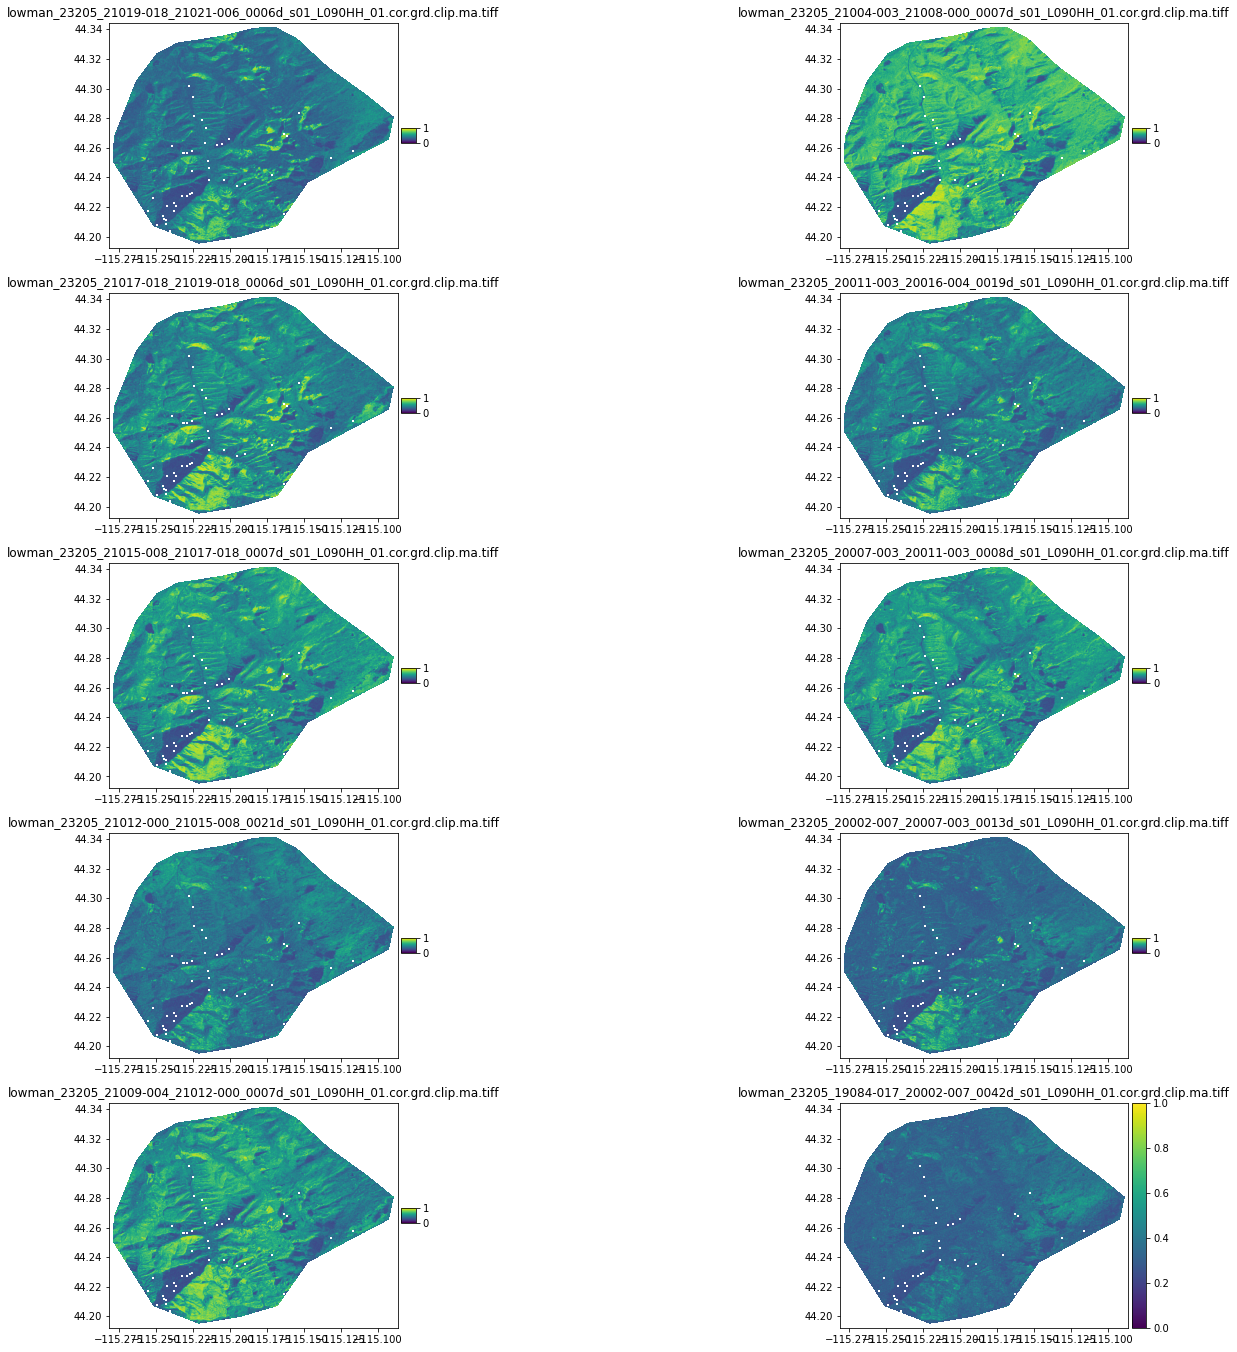

In [101]:
f, axes = plt.subplots( int(len(jpl['coh_clip_ma'])/2), 2, figsize = (24,24))
j = 0
for i, im in enumerate(jpl['coh_clip_ma']):
    if i > 4:
        j = 1
        i -= 5
    ax = axes[i, j]
    show_rio(im, f, ax, vmin = 0, vmax = 1)
    ax.set_title(basename(im))

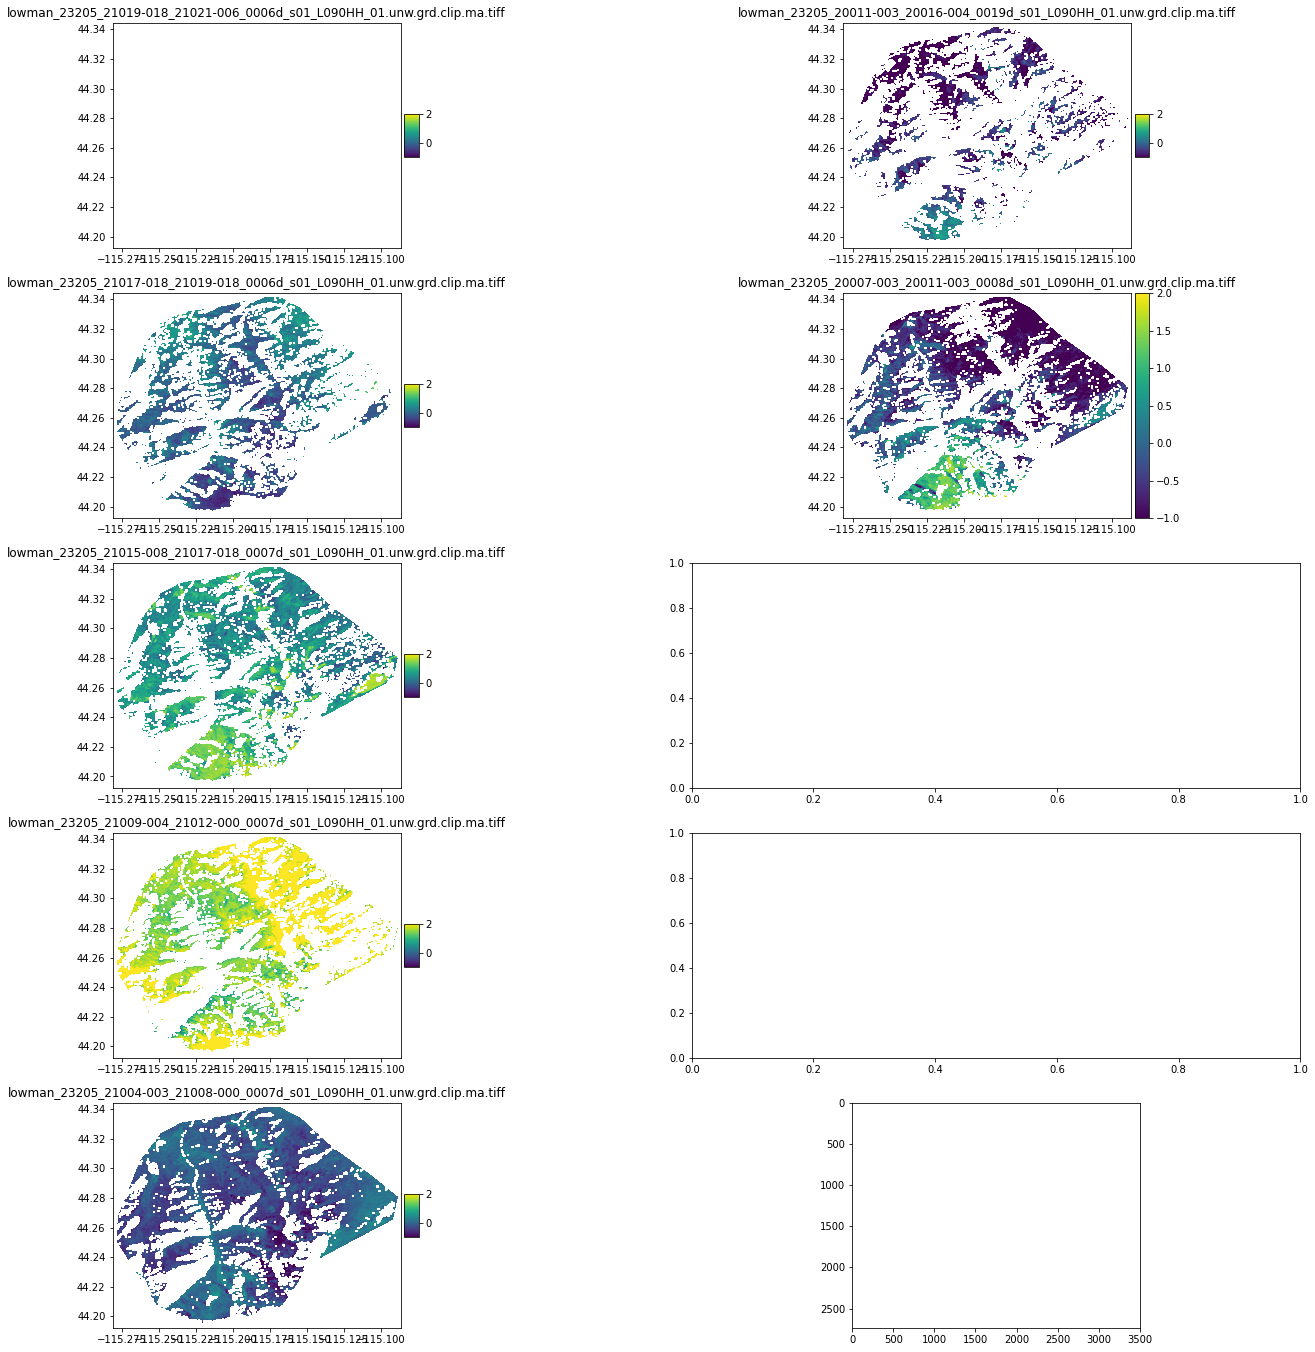

In [123]:
f, axes = plt.subplots( int(len(jpl['coh_clip_ma'])/2), 2, figsize = (24,24))
j = 0
for i, im in enumerate(jpl['unw_clip_ma']):
    if i > 4:
        j = 1
        i -= 5
    ax = axes[i, j]
    show_rio(im, f, ax, vmin = -1, vmax = 2)
    ax.set_title(basename(im))

In [160]:
with rasterio.open(lidar_sd_ma) as sd, rasterio.open(jpl['coh_clip_ma'][5]) as coh, rasterio.open(jpl['unw_clip_ma'][3]) as unw, rasterio.open(inc_crop_reproj_ma) as inc:
    sd = sd.read(1)
    coh = coh.read(1)
    unw = unw.read(1)
    inc = inc.read(1)

In [159]:
def unw_sd(unw, inc, wavelength = 0.238403545, epsilon = 1.3):

    return - (unw * wavelength)/ (4* np.pi) / (np.cos(inc) - np.sqrt(epsilon - (np.sin(inc))**2))
unwrap = np.vectorize(unw_sd)

In [161]:
unw_sd = unwrap(unw, inc)

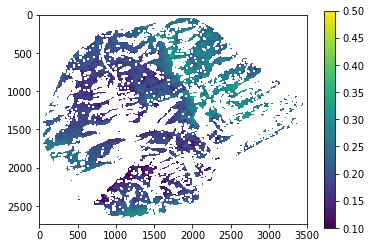

In [163]:
plt.imshow(unw_sd, vmin = 0.1, vmax = 0.5)
plt.colorbar()

Text(0.5, 1.0, 'Snow Depth Change')

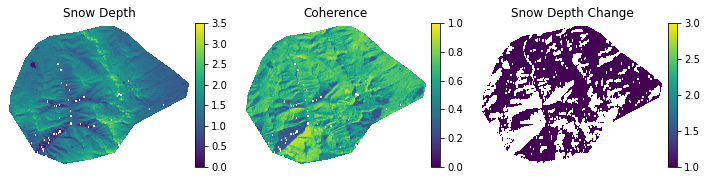

In [130]:
f, axes = plt.subplots(1, 3, figsize = (12,12))
vmin = 0
vmax = 3.5
ax = axes[0]
cbar = ax.imshow(sd, vmin = vmin, vmax = vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(cbar, cax=cax, orientation='vertical')
ax.axis('off')
ax.set_title('Snow Depth')

vmin = 0
vmax = 1
ax = axes[1]
cbar = ax.imshow(coh, vmin = vmin, vmax = vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(cbar, cax=cax, orientation='vertical')
ax.axis('off')
ax.set_title('Coherence')

vmin = -2
vmax = 2
ax = axes[2]
unw_sd = unwrap(unw, inc)
cbar = ax.imshow(unw, vmin = vmin, vmax = vmax)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(cbar, cax=cax, orientation='vertical')
ax.axis('off')
ax.set_title('Snow Depth Change')